## Ford Gobike Trip Data Exploration
## by Phillip Ayebare

## Preliminary Wrangling

> This document explores a dataset containing trip data for Ford Gobike with 183413 rows and 16 columns. In early July 2018, Lyft annouced the acquisition of Motivate (with USD 250 million), that operates bikeshare systems across New York(Citi Bike), Chicago(Divvy), D.C(Captical Bikeshare), Boston(BlueBikes) and San Francisco Bay area (**Ford GoBike**).

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile
import matplotlib.ticker as tick
import datetime
import math
import calendar

from IPython.display import Image

from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap, figure

%matplotlib inline


In [2]:
## load dataset
df= pd.read_csv('/Users/admin/Downloads/201902-fordgobike-tripdata.csv')
df.sample(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
70518,286,2019-02-19 18:16:44.8630,2019-02-19 18:21:31.7920,17.0,Embarcadero BART Station (Beale St at Market St),37.792251,-122.397086,8.0,The Embarcadero at Vallejo St,37.799953,-122.398525,4409,Subscriber,1986.0,Female,No
22600,190,2019-02-26 07:40:21.1440,2019-02-26 07:43:31.6870,90.0,Townsend St at 7th St,37.771058,-122.402717,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,6070,Subscriber,1975.0,Male,No
167213,1885,2019-02-04 17:11:47.6710,2019-02-04 17:43:13.0400,8.0,The Embarcadero at Vallejo St,37.799953,-122.398525,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,663,Subscriber,1979.0,Male,No
34709,570,2019-02-23 21:54:22.5250,2019-02-23 22:03:53.4160,119.0,18th St at Noe St,37.761047,-122.432642,88.0,11th St at Bryant St,37.770030,-122.411726,4822,Subscriber,1980.0,Male,No
16569,430,2019-02-27 08:22:51.6440,2019-02-27 08:30:01.9330,310.0,San Fernando St at 4th St,37.335885,-121.885660,296.0,5th St at Virginia St,37.325998,-121.877120,5895,Subscriber,1994.0,Male,Yes


### Assess data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [4]:
df.isnull().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.member_gender.value_counts()

Male      130651
Female     40844
Other       3652
Name: member_gender, dtype: int64

### Cleaning data

In [7]:
# changing datatypes for time columns
df_trips = df.copy()
df_trips['start_time'] = pd.to_datetime(df_trips['start_time'])
df_trips['end_time'] = pd.to_datetime(df_trips['end_time'])
## changing datatypes for id
df_trips['start_station_id'] = df_trips['start_station_id'].astype('str')
df_trips['end_station_id'] = df_trips['end_station_id'].astype('str')
df_trips['bike_id'] = df_trips['bike_id'].astype('str')
## changing datatypes for user_type and gender
df_trips['user_type'] = df_trips['user_type'].astype('category')
df_trips['member_gender'] = df_trips['member_gender'].astype('category')

df_trips.info()
len(df_trips)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             183412 non-null  int64         
 1   start_time               183412 non-null  datetime64[ns]
 2   end_time                 183412 non-null  datetime64[ns]
 3   start_station_id         183412 non-null  object        
 4   start_station_name       183215 non-null  object        
 5   start_station_latitude   183412 non-null  float64       
 6   start_station_longitude  183412 non-null  float64       
 7   end_station_id           183412 non-null  object        
 8   end_station_name         183215 non-null  object        
 9   end_station_latitude     183412 non-null  float64       
 10  end_station_longitude    183412 non-null  float64       
 11  bike_id                  183412 non-null  object        
 12  user_type       

183412

In [8]:
df_trips.isnull().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id              0
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id                0
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64



| Column name | Number of Rows | Description |
|-|-|-|
| "start_station_name" | 183215 | missing origin data |
| "end_station_name" | 183215 | missing destination data |
| "member_birth_year" | 175147 | missing data will compromise our viz |
| "member_gender" |175147  | missing data will compromise our viz |

In [9]:
## filter data to calculate member age to look for anomalies (outliers)
df_trips['member_age'] = 2019-df_trips['member_birth_year']
df_trips['member_age'].describe()

count    175147.000000
mean         34.193563
std          10.116689
min          18.000000
25%          27.000000
50%          32.000000
75%          39.000000
max         141.000000
Name: member_age, dtype: float64

From the descriptive stats above, the max age of rider data in our data set is 141 years. Such errors needs to be rectified. Lets understand the spread of ages via a boxplot and a histogram.

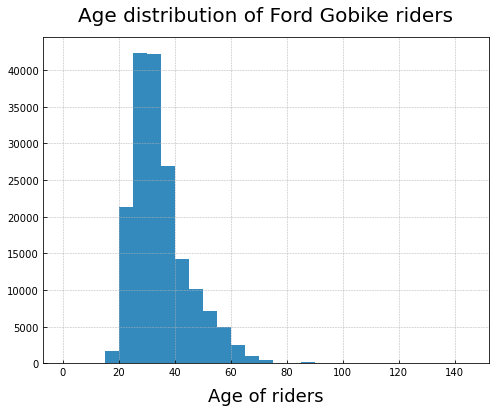

In [10]:
plt.figure(figsize=[8, 6])
bins = np.arange(0, df_trips['member_age'].max()+5, 5)
plt.style.use("bmh")
plt.rcParams.update({"figure.figsize" : (12, 8),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})
plt.xlabel("Age of riders", fontsize=18,labelpad=10)
plt.title("Age distribution of Ford Gobike riders", fontsize=20, y=1.03)
# Plot the histogram for the height column
plt.hist(data=df_trips, x='member_age', bins=bins);

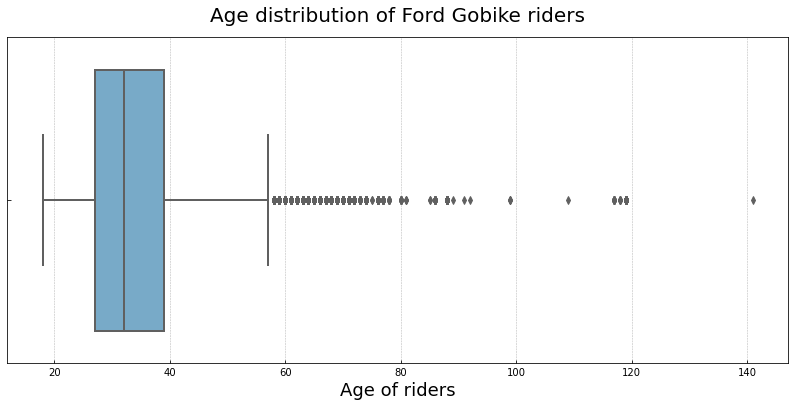

In [11]:
##clearer viz
plt.figure(figsize=(14,6))
sb.boxplot(x='member_age', data=df_trips, palette='Blues', orient='h')
plt.title("Age distribution of Ford Gobike riders", fontsize=20, y=1.03)
plt.xlabel("Age of riders", fontsize=18);
#plt.savefig('image01.png');

#### Source to the analysis below

[source_1](https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles)

[source_2](https://towardsdatascience.com/create-and-customize-boxplots-with-pythons-matplotlib-to-get-lots-of-insights-from-your-data-d561c9883643)

In [12]:
cols = ['member_age'] 

Q1 = df_trips[cols].quantile(0.25)
Q3 = df_trips[cols].quantile(0.75)
IQR = Q3 - Q1

df_trips = df_trips[~((df_trips[cols] < (Q1 - 1.5 * IQR)) |(df_trips[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

df_trips['member_age'].describe()

count    169365.000000
mean         33.183155
std           8.517056
min          18.000000
25%          27.000000
50%          32.000000
75%          38.000000
max          57.000000
Name: member_age, dtype: float64

In [13]:
df_trips.drop(['member_birth_year'], axis=1, inplace=True)

The descriptive stats above (quantitatively representing the visual boxplot and histogram) reveal that the lower and upper bounds for the memeber age column are 18 and 57 years respectively. Ages falling outside these bounds are outliers. We shall do away with members greater than 60 years of age as shown below:

In [14]:
df_trips = df_trips.query('member_age <= 60')
df_trips.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169365 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             169365 non-null  int64         
 1   start_time               169365 non-null  datetime64[ns]
 2   end_time                 169365 non-null  datetime64[ns]
 3   start_station_id         169365 non-null  object        
 4   start_station_name       169171 non-null  object        
 5   start_station_latitude   169365 non-null  float64       
 6   start_station_longitude  169365 non-null  float64       
 7   end_station_id           169365 non-null  object        
 8   end_station_name         169171 non-null  object        
 9   end_station_latitude     169365 non-null  float64       
 10  end_station_longitude    169365 non-null  float64       
 11  bike_id                  169365 non-null  object        
 12  user_type       

In [15]:
## change datatype of member birth year and member age to integer

df_trips['member_age'] = df_trips['member_age'].astype('int')

#### New Distance column to for each ride

[source](https://stackoverflow.com/questions/53697724/getting-distance-from-longitude-and-latitude-using-haversines-distance-formula)

In [16]:
##source to the following code above
import numpy as np
def haversine(lon1, lat1, lon2, lat2, earth_radius=6367):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = earth_radius * c
    return km


# Use pandas shift to place prior values on each row, within a grouped dataframe
df_trips['distance_km'] = df.apply(lambda x: haversine(x['start_station_longitude'], x['start_station_latitude'], x['end_station_longitude'], x['end_station_latitude']), axis=1)
#df_trips['distance_miles_estimates'] = df_trips['distance_km_estimates']*0.621371

# Assign to a new column - use pandas dataframe apply to invoke for each ro

In [17]:
df_trips.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_gender,bike_share_for_all_trip,member_age,distance_km
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,Male,No,35,0.544367
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,Male,No,47,2.702847
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,Other,No,30,0.260575
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,Male,Yes,45,2.407789
6,1147,2019-02-28 23:55:35.104,2019-03-01 00:14:42.588,300.0,Palm St at Willow St,37.317298,-121.884995,312.0,San Jose Diridon Station,37.329732,-121.901782,3803,Subscriber,Female,No,36,2.027278


In [18]:
#### Deriving Year-Month from start time
#df_trips['start_year_month']=df_trips['start_time'].map(lambda x: x.strftime('%Y-%m'))
df_trips['end_year_month']=df_trips['end_time'].map(lambda x: x.strftime('%Y-%m'))
df_trips['start_year_month']=df_trips['start_time'].dt.strftime('%y' + '-' + '%m')
#### deriving year from start time
df_trips['start_year']=df_trips['start_time'].dt.year.astype(int)
df_trips['end_year']=df_trips['end_time'].dt.year.astype(int)
#### deriving month from start time
df_trips['start_month']=df_trips['start_time'].dt.month.astype(int)
df_trips['end_month']=df_trips['end_time'].dt.month.astype(int)
#### deriving day from start time
df_trips['start_weekday']=df_trips['start_time'].dt.day_name()
df_trips['end_weekday']=df_trips['end_time'].dt.day_name()
#### deriving hour from start time
df_trips['start_hour']=df_trips['start_time'].dt.hour
df_trips['end_hour']=df_trips['end_time'].dt.hour

In [19]:
#### Deriving duration minutes from duration seconds
df_trips['duration_min'] = df_trips['duration_sec']/60

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

### What is the structure of your dataset?

> There are 183,412 data trips for fordgobike in the dataset with 16 features which include: *duration_sec, start_time, end_time, start_station_id, start_station_name, start_station_latitude, start_station_longitude, end_station_id, end_station_name, end_station_latitude ,end_station_longitude, bike_id, user_type, member_birth_year, member_gender and bike_share_for_all_trip*.

### What is/are the main feature(s) of interest in your dataset?

> I'm most interested in user_type group characteristics to determine the efficiency of and motivation for using the service.


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I shall tinker with trip durations of different user types since they are dependent on the trip distances and density of networks the e-bikes are meant to operate in. Gender and age will also reveal who the target market is and also how sustainble the service can become for the future.

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

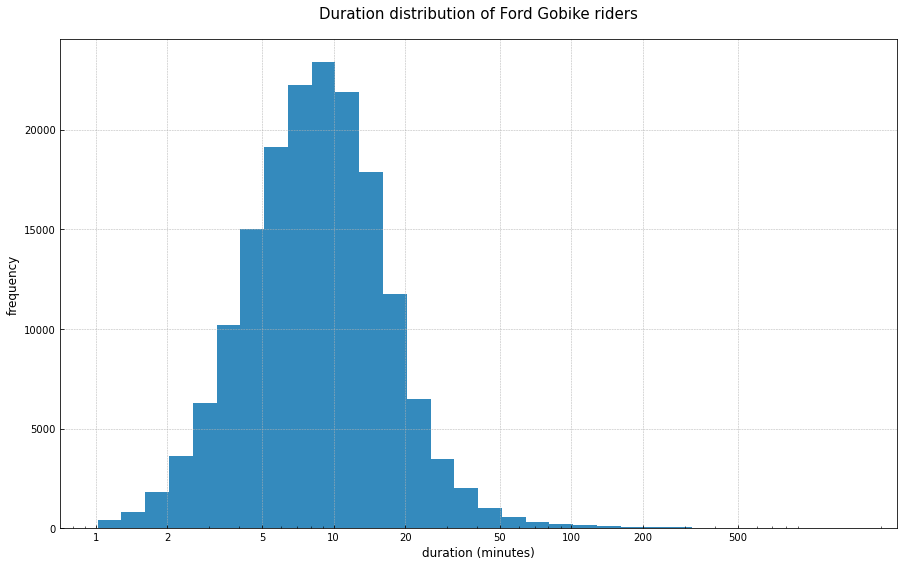

In [20]:
# First let`s explore the distribution of duration varible using histogram
##duration in minutes
plt.figure(figsize=[15,9])
bins= 10** np.arange(np.log10(df_trips.duration_min.min()), np.log10(df_trips.duration_min.max())+0.1, 0.1)
plt.hist(data=df_trips, x='duration_min',bins=bins)
plt.xscale('log')
plt.xticks([1,2,5,10,20,50,100,200,500], [1,2,5,10,20,50,100,200,500])
plt.xlabel('duration (minutes)')
plt.title("Duration distribution of Ford Gobike riders", fontsize=15, y=1.03)
plt.ylabel('frequency');

In [21]:
df_trips['duration_min'].describe(percentiles=[.99])

count    169365.000000
mean         11.722350
std          27.721016
min           1.016667
50%           8.483333
99%          52.984667
max        1409.133333
Name: duration_min, dtype: float64

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

> From the descrptive stats above, 99% of bike rides had a duration of less than 53 minutes Average trip duration fell within the range of 5 - 15 minutes in a normal distribution. This could be due to built environment characteristics such as population density, job density, bicycle and public transit infrastructure, street design, land-use mix and proximity to central areas - near bike-sharing stations (for docking bikes) or previous drop off locations (for bikes in a dockless system). Next, Lets do away with the outliers that rode for more than 70 minutes for purposes of thorough viz.

In [22]:
df_trips = df_trips.query('duration_min <= 70')
df_trips.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168271 entries, 4 to 183411
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             168271 non-null  int64         
 1   start_time               168271 non-null  datetime64[ns]
 2   end_time                 168271 non-null  datetime64[ns]
 3   start_station_id         168271 non-null  object        
 4   start_station_name       168079 non-null  object        
 5   start_station_latitude   168271 non-null  float64       
 6   start_station_longitude  168271 non-null  float64       
 7   end_station_id           168271 non-null  object        
 8   end_station_name         168079 non-null  object        
 9   end_station_latitude     168271 non-null  float64       
 10  end_station_longitude    168271 non-null  float64       
 11  bike_id                  168271 non-null  object        
 12  user_type       

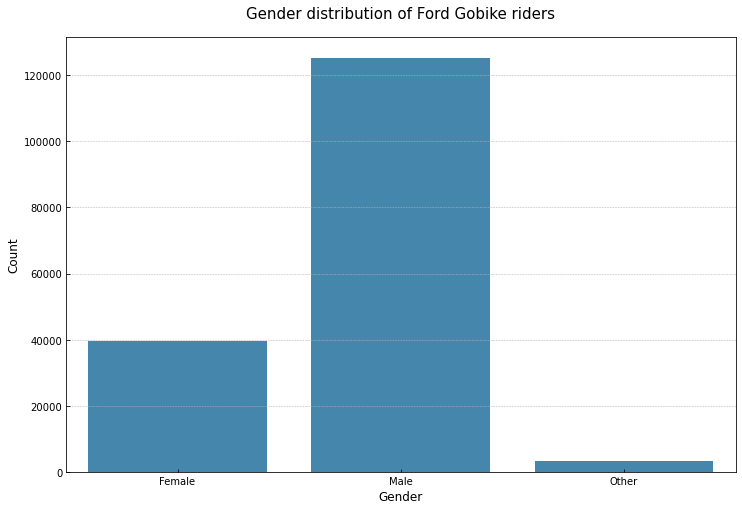

In [23]:
## Second lets explore gender distribution of the riders
base_color = sb.color_palette()[0]
sb.countplot(data=df_trips, x='member_gender', color=base_color);
plt.xlabel('Gender');
plt.title("Gender distribution of Ford Gobike riders", fontsize=15, y=1.03)
plt.ylabel('Count');

In [24]:
df_trips['member_gender'].value_counts()

Male      125071
Female     39674
Other       3526
Name: member_gender, dtype: int64

> Men riders outweigh female riders. over 75% of bike rides are by males

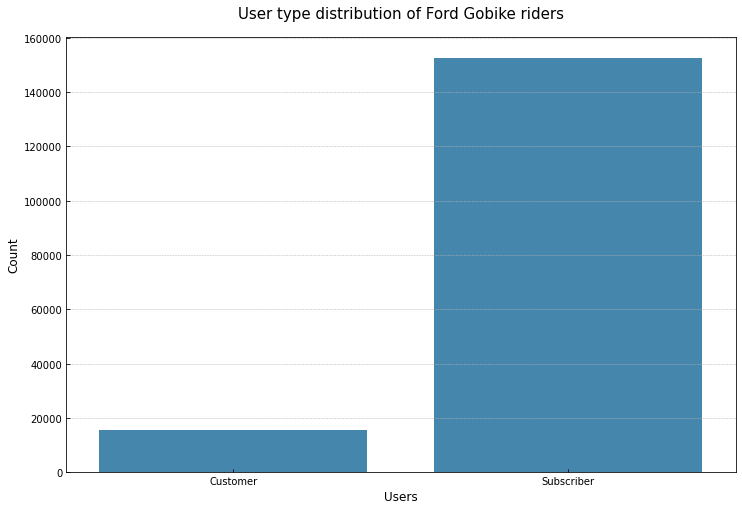

In [25]:
### Third lets explore user_type distribution
sb.countplot(data=df_trips, x='user_type', color=base_color);
plt.xlabel('Users');
plt.title("User type distribution of Ford Gobike riders", fontsize=15, y=1.03)
plt.ylabel('Count');

In [26]:
df_trips['user_type'].value_counts()

Subscriber    152549
Customer       15722
Name: user_type, dtype: int64

> As expected, subscribers were the common users of the bike sharing service

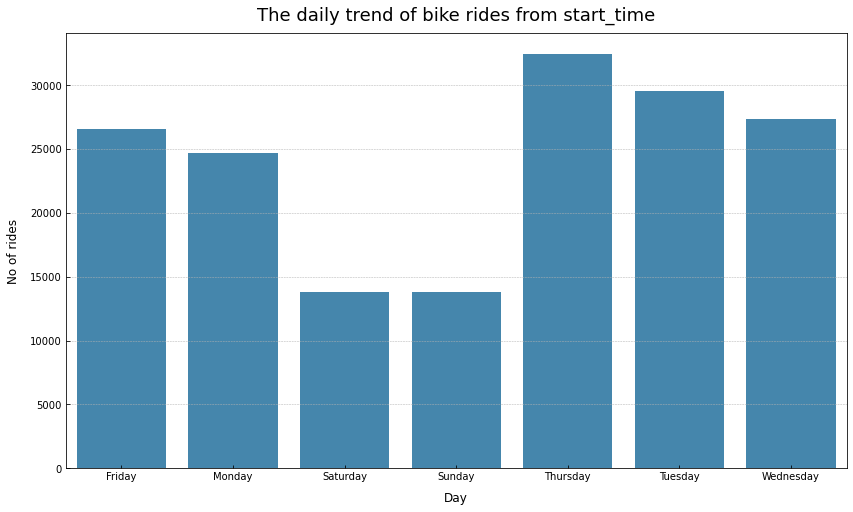

In [27]:
### Fourth, we look at daily trend of riders
plt.figure(figsize=(14,8))
sb.countplot(x='start_weekday', color=base_color, data=df_trips.sort_values(by='start_weekday'))
plt.title('The daily trend of bike rides from start_time', fontsize=18, y=1.015)
plt.xlabel('Day', labelpad=10)
plt.ylabel('No of rides', labelpad=10);

> There ars more rides on Tuesday, Wednesday and Thursday (midweek) probably because people mainly leave their homes for different errands around the city.
We can only find trends for day of the week becasue all the data is collected in 2019 in the month of February

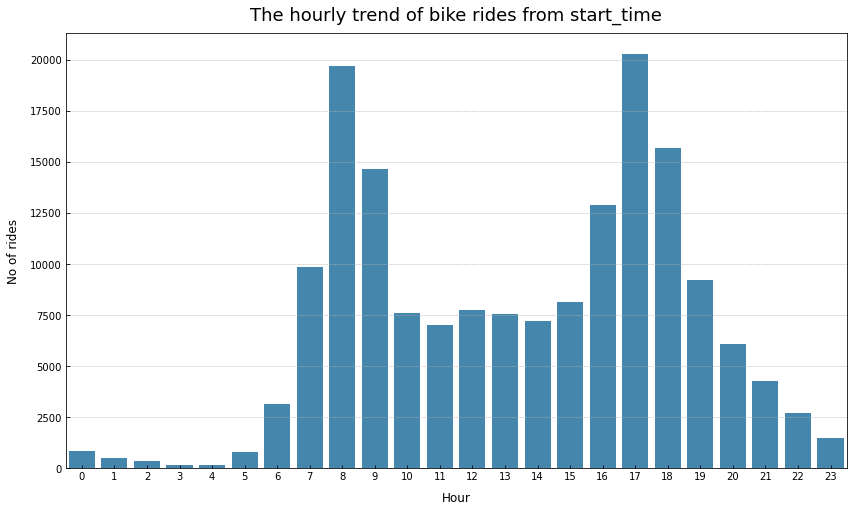

In [28]:
#### Fifth, we look at hourly trends of drivers
plt.figure(figsize=(14,8))
sb.countplot(x='start_hour', color=base_color, data=df_trips.sort_values(by='start_hour'))
plt.title('The hourly trend of bike rides from start_time', fontsize=18, y=1.015)
plt.xlabel('Hour', labelpad=10)
plt.ylabel('No of rides', labelpad=10);

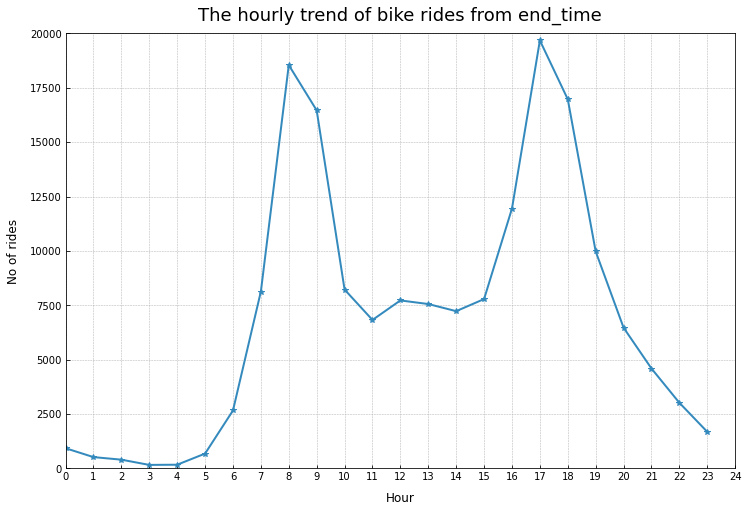

In [29]:
ax = df_trips.groupby('end_hour')['bike_id'].count().plot(kind='line', color=base_color, figsize=(12,8),linestyle='-', marker='*')
ax.set_xlim([0,24])
ax.set_ylim([0,20000])
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.title('The hourly trend of bike rides from end_time', fontsize=18, y=1.015)
plt.xlabel('Hour', labelpad=10)
plt.ylabel('No of rides', labelpad=10);


> It's not surprising that the most active hours are 8-9am and 17-18 hrs which are also peak hours for origin and destination trips

[source](https://dfrieds.com/data-analysis/bin-values-python-pandas.html)

In [30]:
# univariate plots of number of bike rides per age group
df_trips['age_bins'] = pd.cut(x=df_trips['member_age'], bins=[10, 20, 30, 40, 50, 60], 
                              labels=['10-20', '20-30', '30-40','40-50','50-60'])

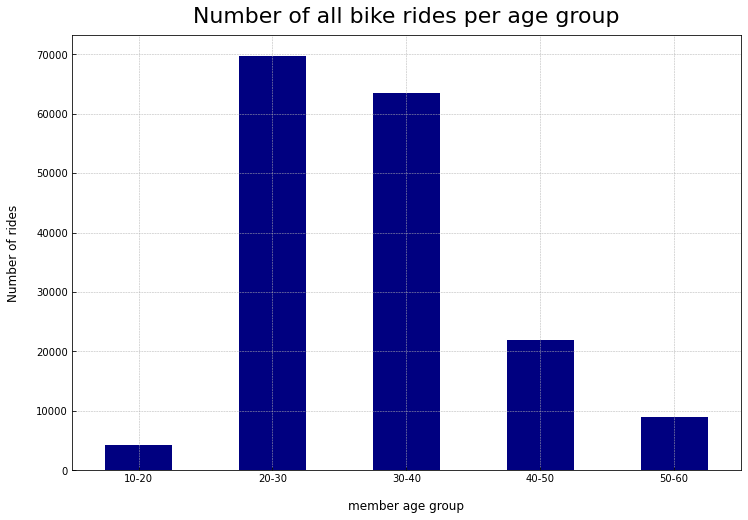

In [31]:
new_color = ['navy']
df_trips.groupby('age_bins')['bike_id'].count().plot(kind='bar', color=new_color, figsize=(12,8))
plt.title('Number of all bike rides per age group', fontsize=22, y=1.015)
plt.xlabel('member age group', labelpad=16)
plt.ylabel('Number of rides', labelpad=16)
plt.xticks(rotation=360)
plt.savefig('image05.png');



Age group 20-30 has the highest number of rides with 70115.

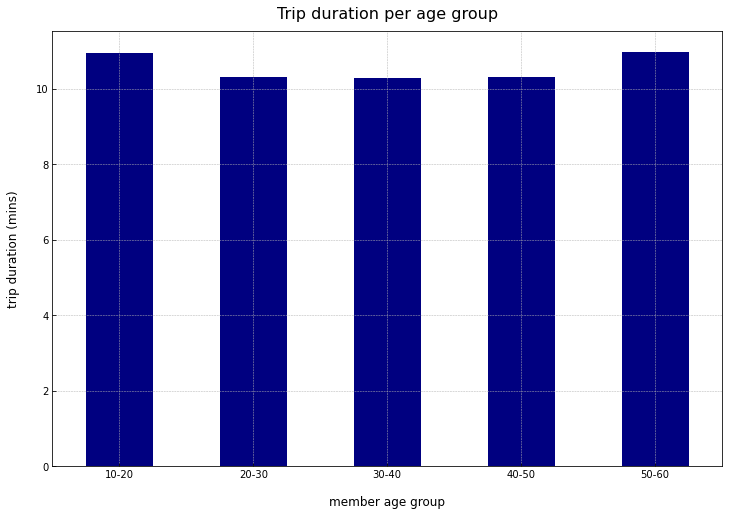

In [32]:
## average trip duration per age bin

df_trips.groupby('age_bins')['duration_min'].mean().plot(kind='bar', color=new_color, figsize=(12,8))
plt.title('Trip duration per age group', fontsize=16, y=1.015)
plt.xlabel('member age group', labelpad=16)
plt.ylabel('trip duration (mins)', labelpad=16)
plt.xticks(rotation=360)
plt.savefig('image05.png');

Trip duration between age groups 20-30, 30-40, and 40-50 appears to be constant at around 10 minutes while thst of 10-20, and 50-60 lies around 11 minutes.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

- From the descrptive stats above, 99% of bike rides had a duration of less than 53 minutes and fell within the range of 5 - 15 minutes in a normal distribution
- Men riders outweigh female riders. Over 75% of bike rides are by males
- It's not surprising that the most active hours are 8-9am and 17-18 hrs which are also peak hours for origin and destination trips.
- There ars more rides on Tuesday, Wednesday and Thursday (midweek) probably because people mainly leave their homes for different errands around the city. We can only find trends for day of the week becasue all the data is collected in 2019 in the month of February.
- Most riders are between the ages of 25-40 years
- No transformation needed. Data was straightforward
- There are a lot more subscribers usage than customers. Subscribers take 90% of the rides
- The user persona of the rider data can be inferred as a 35 year old man subscriber.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

- There we no unusual distibutions.
- some datatypes were changed eg those of start and end times were changed to datatime dtypes.

## Bivariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

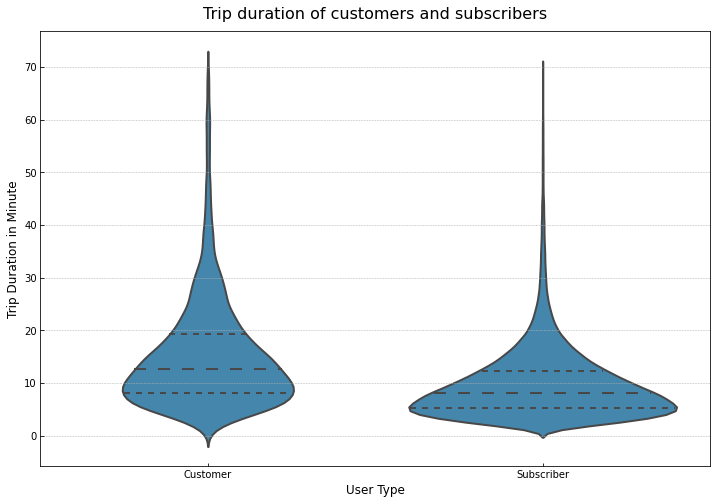

In [33]:
## bivariate plots of trip duration between customers and subscribers
ax =sb.violinplot(data=df_trips, x='user_type', y='duration_min', color=base_color, inner='quartile')

plt.xlabel('User Type');
plt.ylabel('Trip Duration in Minute');
plt.title('Trip duration of customers and subscribers', fontsize=16, y=1.015);

Subscribers ride less minutes than customers who seem to rent the bikes longer. Average trip duration for customers is 12 minutes compared to 9 minutes for subscribers

In [34]:
user_hours = df_trips.groupby(['end_hour','user_type']).size().reset_index()

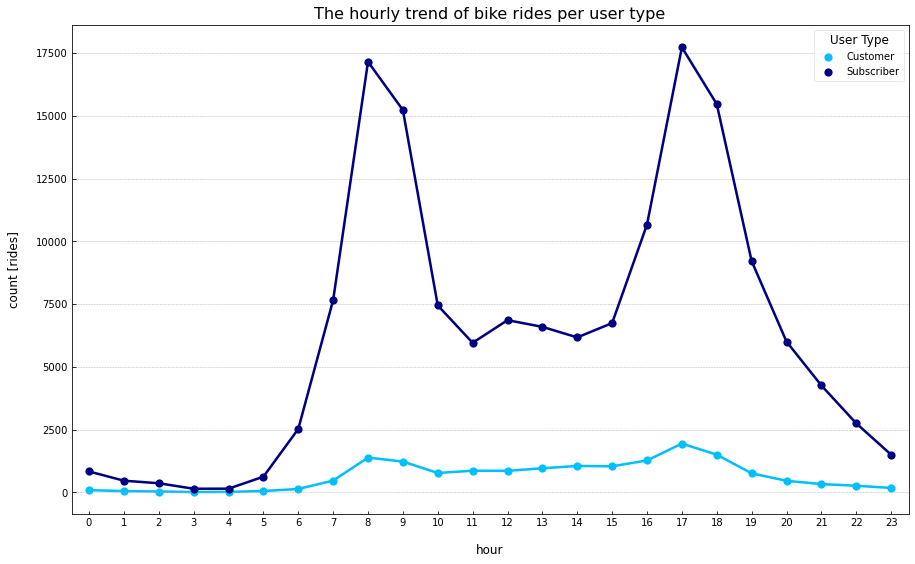

In [35]:
## bivariate plots of hourly trend of bike ride between customers and subscribers

plt.figure(figsize=(15,9))
my_palette = {'Subscriber':'navy', 'Customer':'deepskyblue'}
ax = sb.pointplot(x='end_hour', y=0, hue='user_type', palette=my_palette, scale=.7, data=user_hours)
plt.title('The hourly trend of bike rides per user type', fontsize=16)
plt.xlabel('hour', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':12})
ax = plt.gca()
plt.savefig('image09.png');

Again subscribers have more riders per day than customers. Subscribers and customner have two distinct peaks between 8-9am and 5-6pm, although customers seem to have a steady trend between midmorning to early afternoon hours.

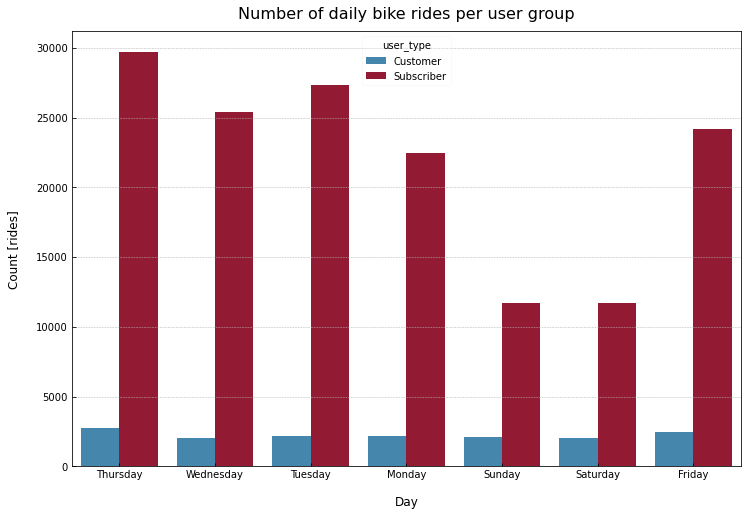

In [36]:
## bivariate plot of daily user_type cycling trends 
ax = sb.countplot(data = df_trips, x = 'start_weekday', hue = 'user_type')
ax.legend(loc = 9, framealpha = 0.2, title = 'user_type');
plt.title('Number of daily bike rides per user group', fontsize=16, y=1.015)
plt.xlabel('Day', labelpad=16)
plt.ylabel('Count [rides]', labelpad=16);

Subscribers' rides take place around commute time, on the contrary customers' rides take place the most during weekend, which represents the main purpose for the user type is different. The former is for convenience around commute time and the latter is more likely for leisure.

In [37]:
distance_usertype = df_trips.groupby("user_type")["distance_km"].mean().reset_index()
distance_usertype
duration_usertype = df_trips.groupby("user_type")["duration_min"].mean().reset_index()
duration_usertype

,user_type,duration_min
0,Customer,15.358010
1,Subscriber,9.839412


[Source](https://stackoverflow.com/questions/60212294/how-to-add-labels-to-a-horizontal-bar-chart-in-matplotlib) for adding labels to horizontal bar chart

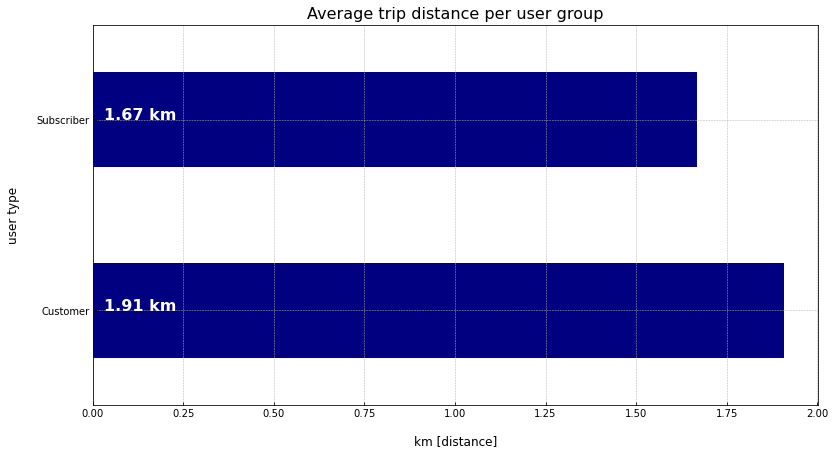

In [38]:
## bivarite plot of average trip distance per user group
ax = df_trips.groupby('user_type')['distance_km'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip distance per user group', fontsize=16)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('km [distance]', labelpad=16)

for i,j in enumerate(distance_usertype['distance_km']):
    ax.text(.03,i,str(round(j,2))+' km', weight='bold', ha='left', fontsize=16, color="white")
plt.savefig('image11.png');

both subscribers and customers trip distance were about the same, which is slightly above 1.5 km. So, I assumeed a lot of customers are more likely use the service for leisure, though they don't tend to go very far.

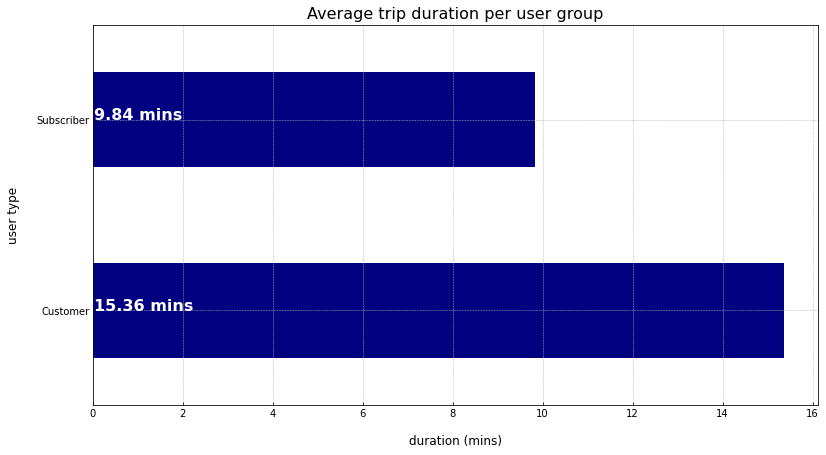

In [39]:
## bivarite plot of average trip duration per user group

ax = df_trips.groupby('user_type')['duration_min'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip duration per user group', fontsize=16)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('duration (mins)', labelpad=16)

for i,j in enumerate(duration_usertype['duration_min']):
    ax.text(.03,i,str(round(j,2))+' mins', weight='bold', ha='left', fontsize=16, color="white")


Customer trips last way longer than subscriber trips at 15.36 minutes on average compared to 9.84 mins for subscribers

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> More than 70% of users are in 20 to 40 years old age(when mean age is 35). Plus, 75% of bike rides by male as mentioned before. Moreover, the peak bike rides time for all members is around commute time(a quarter of the total rides happen exactly at 8am and 5pm).the user persona of the Ford goBike can be inferred as a 35 old subscriber male riding an average of 1.7km and mainly in peak hours of 8 am and 5pm  .

>Customer trips last way longer than subscriber trips at 15.36 minutes on average compared to 9.84 mins for subscribers

> both subscribers and customers trip distance were about the same, which is slightly above 1.5 km. So, I assumeed a lot of customers are more likely use the service for leisure, though they don't tend to go very far.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Customer riders are very few compared to subscribers but ride the longest. Probably for leisure.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

In [40]:
## multivariate plots of daily trip duration distribution vary between customers and subscribers 
#ax = sb.violinplot(y="end_weekday", x="distance_km",split=True, hue="user_type", data=df_trips)
#ax.set_title('Distribution of daily trips per user_type', fontsize=16);
#plt.title('Duration of daily bike rides per user group', fontsize=16, y=1.015)
#plt.ylabel('Day', labelpad=16)
#plt.xlabel('distance (km)', labelpad=16);

In [41]:
#ax = sb.barplot(data = df_trips, x = 'start_weekday',y="distance_km", hue = 'user_type')
#ax.legend(loc = 9, framealpha = 0.2, title = 'user_type');
#plt.title('Number of daily bike rides per user group', fontsize=16, y=1.015)
#plt.xlabel('Day', labelpad=16)
#plt.ylabel('Count [rides]', labelpad=16);

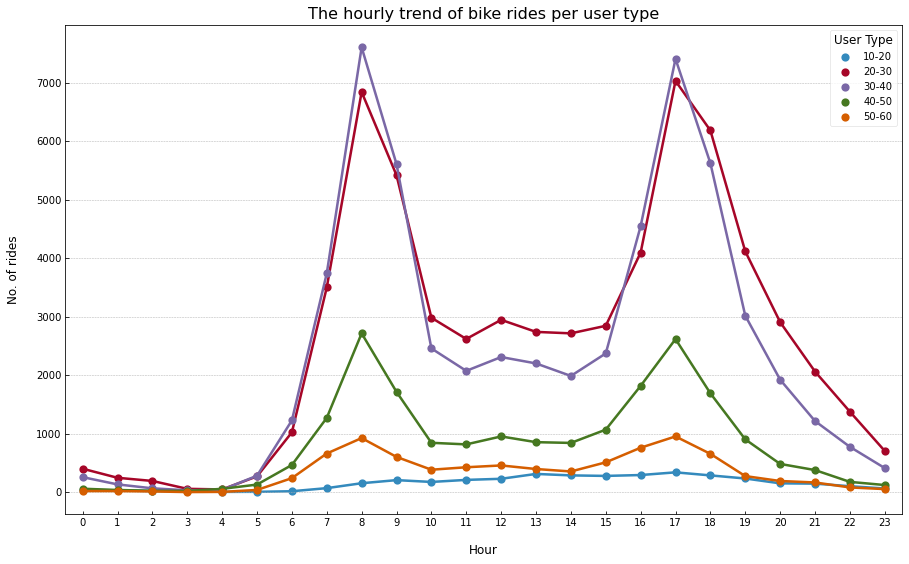

In [42]:
### multivariate plots of hourly trend of subscribers age groups
sub_age = df_trips[df_trips['user_type']=='Subscriber'].groupby(['start_hour', 'age_bins']).agg({'bike_id':'count'}).reset_index()

plt.figure(figsize=(15,9))
ax = sb.pointplot(x='start_hour', y='bike_id', hue='age_bins', scale=.7, data=sub_age)
plt.title('The hourly trend of bike rides per user type', fontsize=16)
plt.xlabel('Hour', labelpad=16)
plt.ylabel('No. of rides', labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':12})
ax = plt.gca()
plt.savefig('image09.png');

10 to 20 years old group might not be qualified for the criteria becaue they have very few rides throughout the day.
the rest of the user groups espouse a similar pattern of peak hour rides between 8-9am and 5-6pm. The 20-30s ad 30-40s subscribers contribute most to the number of riders. The older one grows the less one is likely to cycle.This could be due to accrued status and finanical stability or health related.
Dockless bike-sharing systems are suggested to be more popular among young or middle-aged groups

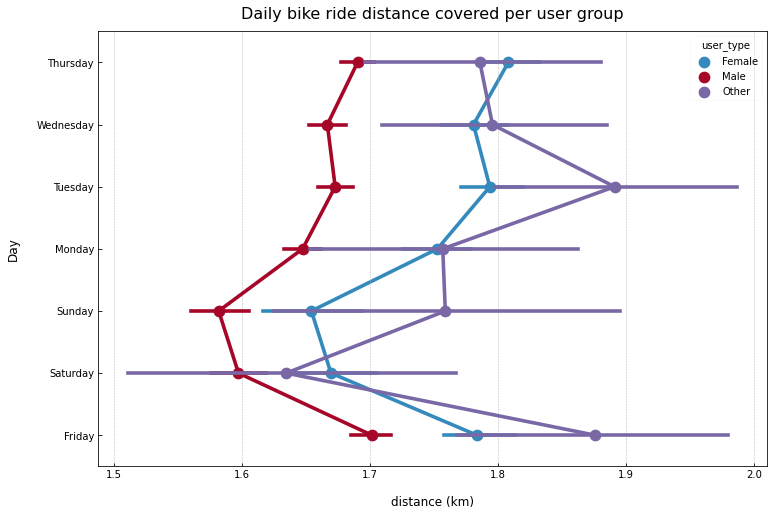

In [43]:
##daily bike ride distance covered per user group
ax = sb.pointplot(data = df_trips, y = 'start_weekday',x="distance_km", hue = 'member_gender')
ax.legend(loc='middle right', framealpha = 0.2, title = 'user_type');
plt.title('Daily bike ride distance covered per user group', fontsize=16, y=1.015)
plt.ylabel('Day', labelpad=16)
plt.xlabel('distance (km)', labelpad=16);

Inasmuch as the plot may be misleading by making a small difference in distance travelled seem much larger than it actually is by zooming in on the difference, Females travel longer than males by 110m everyday except for friday and the weekend where they travel less km. This

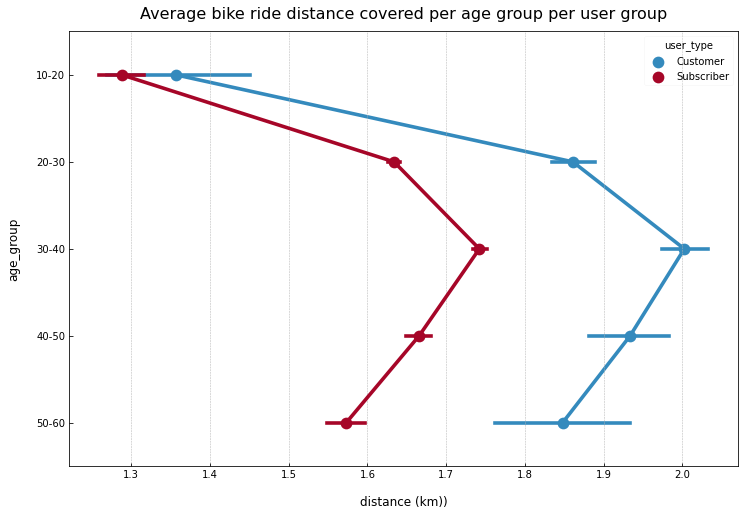

In [44]:
##multivariate plot of bike ride distance covered per age group per user group

ax = sb.pointplot(data = df_trips, y = 'age_bins',x="distance_km", hue = 'user_type')
ax.legend(loc='middle right', framealpha = 0.2, title = 'user_type');
plt.title('Average bike ride distance covered per age group per user group', fontsize=16, y=1.015)
plt.ylabel('age_group', labelpad=16)
plt.xlabel('distance (km))', labelpad=16);

Inasmuch as the plot may be misleading by making a small difference in distance travelled seem much larger than it actually is by zooming in on the difference, customers travel longer than males by over 300m for all age groups. There is a similar trend where distance covered peaks in ones mid ages and reduces in later years (40 and above) for both customers and subscribers

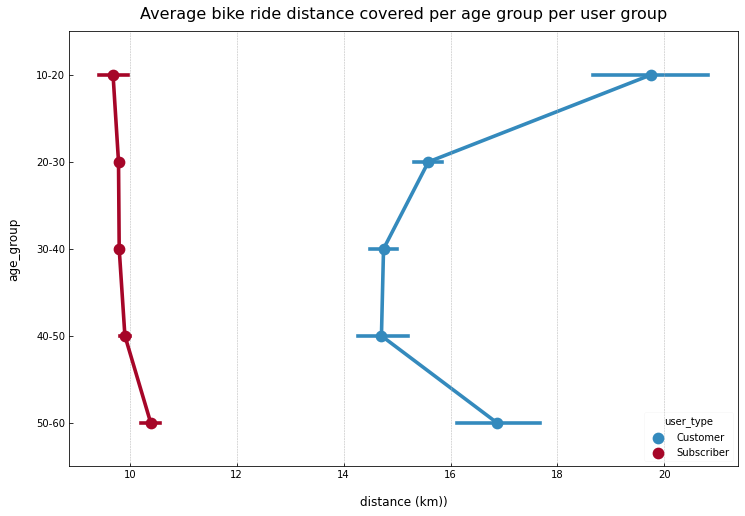

In [45]:
##multivariate plot of bike ride trip duration per age group per user group
ax = sb.pointplot(data = df_trips, y = 'age_bins',x="duration_min", hue = 'user_type')
ax.legend(loc='middle right', framealpha = 0.2, title = 'user_type');
plt.title('Average bike ride distance covered per age group per user group', fontsize=16, y=1.015)
plt.ylabel('age_group', labelpad=16)
plt.xlabel('distance (km))', labelpad=16);

For subscribers the trip duration is higher for older age - though not significantly. The same trend is seen among customers where 50-60 yr olds ride longer than 20-50 year olds. Bizzare but probably because of health related reasons. 

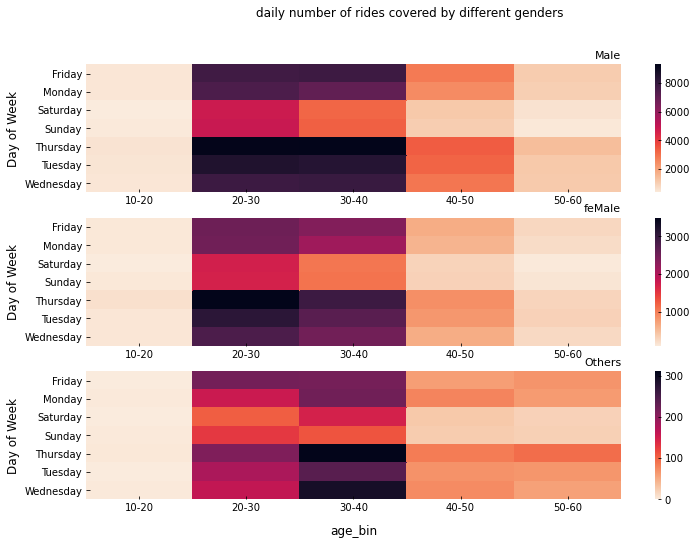

In [46]:
plt.suptitle('daily number of rides covered by different genders')

plt.subplot(3, 1, 1)
males = df_trips.query('member_gender == "Male"')
ct_counts = males.groupby(['start_weekday', 'age_bins']).size()
ct_counts = ct_counts.reset_index(name='count')
ct_counts = ct_counts.pivot(index='start_weekday', columns='age_bins', values='count')
sb.heatmap(ct_counts, cmap='rocket_r');
plt.title('Male', loc='right',fontsize=11);
plt.xlabel('Hour of Day',labelpad=12);
plt.ylabel('Day of Week');

plt.subplot(3, 1, 2)
#bins_x = np.arange(0, 0.5, 0.05)
females = df_trips.query('member_gender == "Female"')
ct_counts = females.groupby(['start_weekday', 'age_bins']).size()
ct_counts = ct_counts.reset_index(name='count')
ct_counts = ct_counts.pivot(index='start_weekday', columns='age_bins', values='count')
sb.heatmap(ct_counts, cmap='rocket_r', );
plt.title('feMale', loc='right',fontsize=11);
plt.xlabel('Hour of Day',labelpad=12);
#plt.xticks(bins_x)
plt.yticks(rotation=0, ha='right')
plt.ylabel('Day of Week');

plt.subplot(3, 1, 3)
#bins_x = np.arange(0, 0.5, 0.05)
others = df_trips.query('member_gender == "Other"')
ct_counts = others.groupby(['start_weekday', 'age_bins']).size()
ct_counts = ct_counts.reset_index(name='count')
ct_counts = ct_counts.pivot(index='start_weekday', columns='age_bins', values='count')
sb.heatmap(ct_counts, cmap='rocket_r', );
plt.title('Others', loc='right',fontsize=11);
plt.xlabel('age_bin',labelpad=12);
#plt.xticks(bins_x)
plt.yticks(rotation=0, ha='right')
plt.ylabel('Day of Week');

For male riders, 20-30 and 30-40 yr olds ride most on Thursday and tuesday (over 8000 rides)
for female riders, 20-30 years olds ride the most on Thursdays but with far less peak rides (3000 rides)
for other riders, 30-40 year olds dominate the rider charts on wednesday and thursday with 300 rides

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> 20-40 year old male subscribers (average age of 35) riding an average of 1.7km on Thurday and Friday (longer than other days). The multivariate plots reinforced some of the patterns discovered in the bivariate and univariate exploration, the relationship between the multiple variables plotted are visualized altogether and information are presented combined.
> 
### Were there any interesting or surprising interactions between features?

> Females covering longer distances than males came as a surprise given the disproportionately larger number of males 


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

In [47]:
df_trips.to_csv('trip_data.csv',index=False)

In [48]:
jupyter nbconvert Ford_goBike.ipynb --to slides--post serve --template output_toggle

SyntaxError: invalid syntax (<ipython-input-48-cc3709098021>, line 1)